# Project: Health risk profiling
<b>Author:</b> Joeri van Wijngaarden<br>
<b>Date:</b> 10-06-2019<br>
<b>Source:</b> <a>http://joerivanwijngaarden.com/project-health-risk-profiling.html</a><br>
<b>Github:</b> <a>https://github.com/tingidev/jvw-projects/tree/master/project-4-health-risk-profiling</a>

<p>This project is based on data from the Behaviour Risk Factor Surveillance System (BRFSS), provided by the US Center For Disease Control and Prevention. The BRFSS’s objective is to collect uniform state-specific data on health risk behaviors, chronic diseases and conditions, access to health care, and use of preventive health services related to the leading causes of death and disability in the United States.</p>
<p>The datasets available are found here:</p>
<ul>
    <li>2017 - <a>https://www.cdc.gov/brfss/annual_data/annual_2017.html</a></li>
    <li>2016 - <a>https://www.cdc.gov/brfss/annual_data/annual_2016.html</a></li>
    <li>2015 - <a>https://www.cdc.gov/brfss/annual_data/annual_2015.html</a></li>
</ul>

### Data Accessibility
<p>The above URL will link you to all supporting documentation on the content of the data. However, the US government makes data available only in .XPT format, which is a SAS-associated binary file. I do not have access to SAS, and instead used a nice package called <strong><i>xport</i></strong> (<a>https://pypi.org/project/xport/</a>) to convert it to a .CSV file and load it into Python. Conversions only work for 2015-2017 data, as any older datasets give critical errors.</p>

In [2]:
# Import friends
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
%matplotlib inline
sns.set_style("darkgrid")

## Functions

In [4]:
def get_odds_ratio(col_name):
    # Calculates the odds ratio (OR), a statistic that quantifies the strength of the association 
    # between two events, A and B. The odds ratio is defined as the ratio of the odds of A in the 
    # presence of B and the odds of A in the absence of B (https://en.wikipedia.org/wiki/Odds_ratio)
    
    risk_group = data_risk[col_name] > 0
    
    # Risk group
    Ne = sum(risk_group) # total
    He = sum(data_target[risk_group] > 0) # good health
    De = sum(data_target[risk_group] < 0) # bad health
    
    # Non-risk group
    Nn = sum(~risk_group) # total
    Hn = sum(data_target[~risk_group] > 0) # good health
    Dn = sum(data_target[~risk_group] < 0) # bad health
    
    RR = (De/Ne) / (Dn/Nn)
    OR = (De/He) / (Dn/Hn)
    
    return(OR)

## Load Data

In [67]:
# Load raw data from .CSV format and store as a pandas DataFrame
# Note: takes a few mins, running some exceptions per file for column incompatability

base_folder = 'C:/Users/jvw/Documents/python-scripts/brfss/data/'
years = ['2017', '2016', '2015']

for year in years:
#     fname = base_folder + 'LLCP' + year + 'XPT/LLCP' + year + '.csv'
#     df = pd.read_csv(fname, delimiter=',', error_bad_lines=False)
#     df.to_pickle('./pickled/df' + year + '.pkl')
    print('Saved DataFrame for year:', year)

Saved DataFrame for year: 2017
Saved DataFrame for year: 2016
Saved DataFrame for year: 2015


In [5]:
# Load pickled DataFrames (instead of above cell)
years = ['2017', '2016', '2015']
df = pd.read_pickle('C:/Users/jvw/Documents/python-scripts/brfss/pickled/df' + years[0] + '.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/jvw/Documents/python-scripts/brfss/pickled/df2017.pkl'

## <p id='general'>General data overview</p>
<p>You can see in the cell below that we have nearly half a million participants, and data spreads 358 variables. When you read the documentation you'll see that many columns are used in tandem to compute total scores. We will go through the different categories and compute these final variables, giving us a handful of useful factors to analyze. Each section will have an overview of distributions across the population:</p>
<ul>
    <li>[General overview](#general)</li>
    <li>[Participant demographics](#demographics)</li>
</ul>
<ul>
    <li>[Section 1: General health](#sec1)</li>
    <li>[Section 2: Healthy days](#sec2)</li>
    <li>[Section 3: Health coverage](#sec3)</li>
    <li>[Section 4: Blood pressure](#sec4)</li>
    <li>[Section 5: Cholesterol](#sec5)</li>
    <li>[Section 6: Chronic conditions](#sec6)</li>
    <li>[Section 9: Smoking](#sec9)</li>
    <li>[Section 11: Drinking](#sec11)</li>
    <li>[Section 12: Diet](#sec12)</li>
    <li>[Section 13: Exercise](#sec13)</li>
    <li>[Section 14: Seatbelts](#sec14)</li>
    <li>[Section 15: Immunization](#sec15)</li>
    <li>[Section 16: HIV/AIDS](#sec16)</li>
</ul>
<ul>
    <li>[Data preparation](#dataprep)</li>
    <li>[Data analysis](#analysis)</li>
</ul>

In [5]:
# Sample overview
print(df.shape)
print('Number of participants:', len(df.index))
print('Number of variables:', len(df.columns))
df.head(10)

(449984, 358)
Number of participants: 449984
Number of variables: 358


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,1.0,1.0,1302017,1,30,2017,1100.0,2017000001,2.017000e+09,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1122017,1,12,2017,1100.0,2017000002,2.017000e+09,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1102017,1,10,2017,1100.0,2017000003,2.017000e+09,1.0,...,3.0,2.0,2.0,4.0,2.0,1.0,1.0,1.0,1.0,2.0
3,1.0,1.0,2082017,2,8,2017,1200.0,2017000004,2.017000e+09,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN
4,1.0,1.0,1302017,1,30,2017,1100.0,2017000005,2.017000e+09,1.0,...,3.0,2.0,2.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0
5,1.0,1.0,1302017,1,30,2017,1100.0,2017000006,2.017000e+09,1.0,...,2.0,2.0,2.0,4.0,2.0,1.0,1.0,1.0,2.0,2.0
6,1.0,1.0,1052017,1,5,2017,1100.0,2017000007,2.017000e+09,1.0,...,3.0,2.0,2.0,4.0,2.0,1.0,1.0,2.0,2.0,2.0
7,1.0,1.0,2022017,2,2,2017,1100.0,2017000008,2.017000e+09,1.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
8,1.0,1.0,1242017,1,24,2017,1100.0,2017000009,2.017000e+09,1.0,...,3.0,2.0,2.0,4.0,2.0,1.0,2.0,1.0,9.0,2.0
9,1.0,1.0,1122017,1,12,2017,1100.0,2017000010,2.017000e+09,1.0,...,1.0,1.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,1.0


Number of states involved: 53


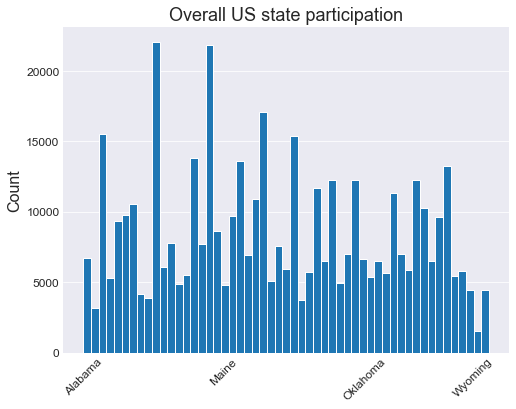

In [335]:
# US state participation
states = df['_STATE'].copy().dropna(axis=0)
uniq = np.sort(states.unique())
print('Number of states involved:', len(uniq))

# Rescale
for i, val in enumerate(uniq):
    states.replace(val, i, inplace=True)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(axis='x')
ax.hist(states, bins=len(uniq), edgecolor='w')
ax.set_title('Overall US state participation', fontsize=18)
ax.set_ylabel('Count', fontsize=16)
ax.set_xticks([0,18,36,50])
ax.set_xticklabels(['Alabama','Maine','Oklahoma','Wyoming'], rotation=45, ha="center", fontsize=12)
ax.tick_params(axis='y', which='major', labelsize=12)

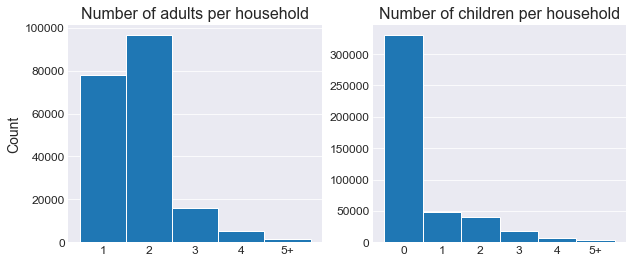

In [333]:
# Number of adults per household
n_adults = df['NUMADULT'].copy().dropna(axis=0)
n_children = df['_CHLDCNT'].copy().dropna(axis=0).drop(df[df['_CHLDCNT']>6].index)
n_adults[n_adults>5] = 5
n_children = n_children-1

# Plot
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

for i, ax in enumerate(axs):
    ax.grid(axis='x')
    if i==0:
        ax.hist(n_adults, range=[1, 6], bins=5, edgecolor='w')
        ax.set_title('Number of adults per household', fontsize=16)
        ax.set_xticks(np.linspace(1.5, 5.5, 5))
        ax.set_xticklabels(['1','2','3','4','5+'])
        ax.set_ylabel('Count', fontsize=14)
    else:
        ax.hist(n_children, bins=np.linspace(-0.5, 5.5, 7), edgecolor='w')
        ax.set_title('Number of children per household', fontsize=16)
        ax.set_xticks(np.linspace(0, 5, 6))
        ax.set_xticklabels(['0','1','2','3','4','5+'])
    ax.tick_params(axis='both', which='major', labelsize=12)

#### [to overview](#general)
## <p id='demographics'>Participant demographics</p>

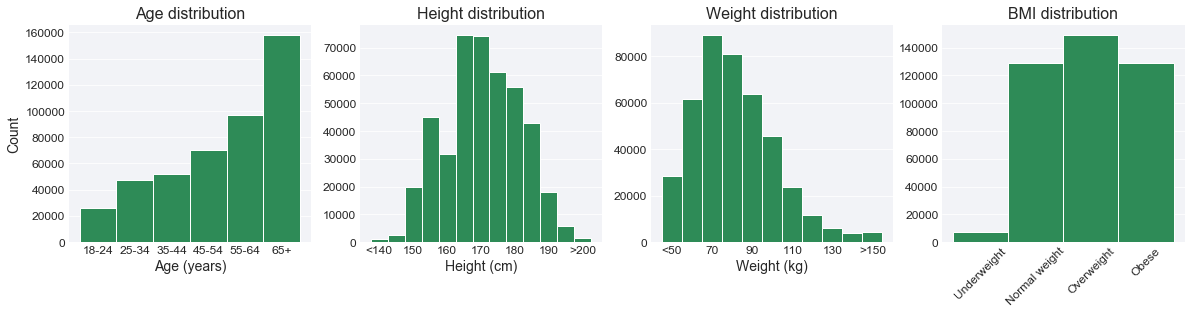

In [363]:
# AGE / HEIGHT / WEIGHT / BMI
age_grp = df['_AGE_G'].copy().dropna(axis=0)
height = df['HTM4'].copy().dropna(axis=0)
weight = (df['WTKG3'].copy().dropna(axis=0)/100).astype(int)
bmi = (df['_BMI5'].copy().dropna(axis=0)/100).astype(int)
bmi_grp = df['_BMI5CAT'].copy().dropna(axis=0)
height[height<140] = 140
height[height>200] = 200
weight[weight<50] = 50
weight[weight>150] = 150

# Plot
fig, axs = plt.subplots(ncols=4, figsize=(20, 4))
col = 'seagreen'
backcol = '#f2f3f7'

for i, ax in enumerate(axs):
    ax.grid(axis='x')
    if i==0:
        ax.hist(age_grp, range=[1, 7], bins=6, edgecolor='w', facecolor=col)
        ax.set_title('Age distribution', fontsize=16)
        ax.set_xlabel('Age (years)', fontsize=14)
        ax.set_xticks(np.linspace(1.5, 6.5, 6))
        ax.set_xticklabels(['18-24','25-34','35-44','45-54','55-64','65+'])
        ax.set_ylabel('Count', fontsize=14)
    elif i==1:
        ax.hist(height, bins=np.linspace(137.5, 202.5, 14), edgecolor='w', facecolor=col)
        ax.set_title('Height distribution', fontsize=16)
        ax.set_xlabel('Height (cm)', fontsize=14)
        ax.set_xticks(np.linspace(140, 200, 7))
        ax.set_xticklabels(['<140','150','160','170','180','190','>200'])
    elif i==2:
        ax.hist(weight, bins=np.linspace(45, 155, 12), edgecolor='w', facecolor=col)
        ax.set_title('Weight distribution', fontsize=16)
        ax.set_xlabel('Weight (kg)', fontsize=14)
        ax.set_xticks(np.linspace(50, 150, 6))
        ax.set_xticklabels(['<50','70','90','110','130','>150'])
    else:
        ax.hist(bmi_grp, range=[1, 5], bins=4, edgecolor='w', facecolor=col)
        ax.set_title('BMI distribution', fontsize=16)
        ax.set_xticks([1.5,2.5,3.5,4.5])
        ax.set_xticklabels(['Underweight','Normal weight','Overweight','Obese'], rotation=45, ha='center')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_facecolor(backcol)

# plt.savefig('./images/img2.png',bbox_inches='tight')

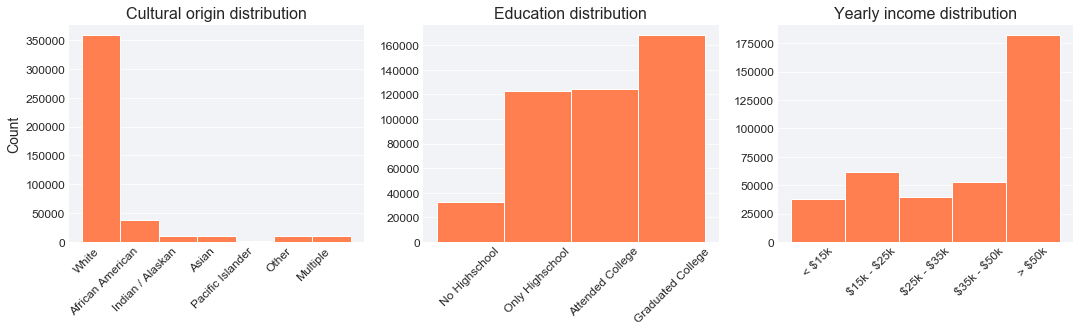

In [364]:
# ORIGIN / EDUCATION / INCOME
origin = df['_MRACE1'].copy().dropna(axis=0)
education = df['_EDUCAG'].copy().dropna(axis=0)
income_grp = df['_INCOMG'].copy().dropna(axis=0)

# Plot 
fig, axs = plt.subplots(ncols=3, figsize=(18, 4))
col = 'coral'

for i, ax in enumerate(axs):
    ax.grid(axis='x')
    if i==0:
        ax.hist(origin, bins=np.linspace(0.5, 7.5, 8), edgecolor='w', facecolor=col)
        ax.set_title('Cultural origin distribution', fontsize=16)
        ax.set_xticks(np.linspace(1, 7, 7))
        ax.set_xticklabels(['White','African American','Indian / Alaskan','Asian','Pacific Islander','Other','Multiple'], \
                           rotation=45, ha='right')
        ax.set_ylabel('Count', fontsize=14)
    elif i==1:
        ax.hist(education, bins=np.linspace(0.5, 4.5, 5), edgecolor='w', facecolor=col)
        ax.set_title('Education distribution', fontsize=16)
        ax.set_xticks(np.linspace(1, 4, 4))
        ax.set_xticklabels(['No Highschool','Only Highschool','Attended College','Graduated College'], rotation=45, \
                           ha='center')
    else:
        ax.hist(income_grp, bins=np.linspace(0.5, 5.5, 6), edgecolor='w', facecolor=col)
        ax.set_title('Yearly income distribution', fontsize=16)
        ax.set_xticks(np.linspace(1, 5, 5))
        ax.set_xticklabels(['< \$15k','\$15k - \$25k','\$25k - \$35k','\$35k - \$50k','> \$50k'], \
                           rotation=45, ha='center')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_facecolor(backcol)

# plt.savefig('./images/img3.png',bbox_inches='tight')

#### [to overview](#general)
## <p id='sec1'>Section 1: General health</p>

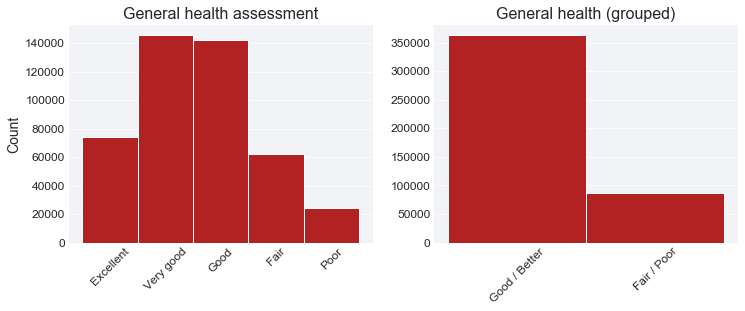

In [362]:
# General health
gen_health = df['GENHLTH'].copy().dropna(axis=0).drop(df[df['GENHLTH']>5].index)
gen_health_grp = df['_RFHLTH'].copy().dropna(axis=0).drop(df[df['_RFHLTH']>2].index)

#Plot
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
col = 'firebrick'

for i, ax in enumerate(axs):
    ax.grid(axis='x')
    if i==0:
        ax.hist(gen_health, range=[1, 6], bins=5, edgecolor='w', facecolor=col)
        ax.set_xticks(np.linspace(1.5, 5.5, 5))
        ax.set_xticklabels(['Excellent','Very good','Good','Fair','Poor'], rotation=45, fontsize=14)
        ax.set_title('General health assessment', fontsize=16)
        ax.set_ylabel('Count', fontsize=14)
    else:
        ax.hist(gen_health_grp, range=[1, 3], bins=2, edgecolor='w', facecolor=col)
        ax.set_xticks(np.linspace(1.5, 2.5, 2))
        ax.set_xticklabels(['Good / Better','Fair / Poor'], rotation=45)
        ax.set_title('General health (grouped)', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_facecolor(backcol)

# plt.savefig('./images/img1.png',bbox_inches='tight')

#### [to overview](#general)
## <p id='sec2'>Section 2: Healthy days (physical &amp; mental)</p>

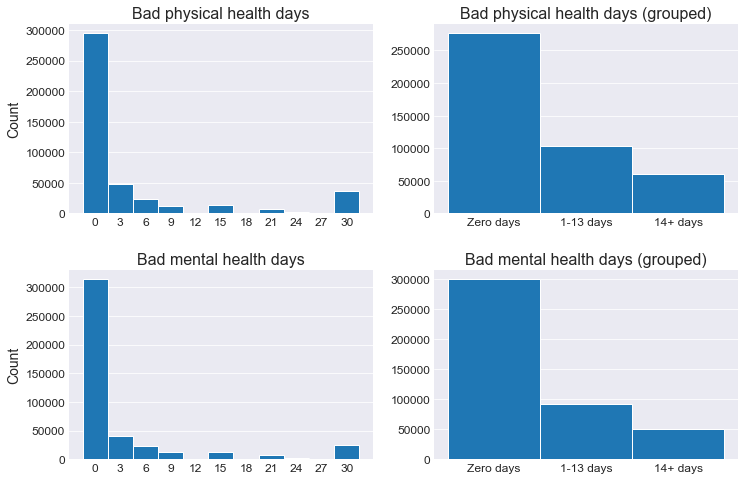

In [15]:
# Number of bad health days
health_days_phys = df['PHYSHLTH'].copy().dropna().drop(df[((df['PHYSHLTH']>30) & (df['PHYSHLTH']!=88))].index)
health_days_phys[health_days_phys==88] = 0
health_days_ment = df['MENTHLTH'].copy().dropna().drop(df[((df['MENTHLTH']>30) & (df['MENTHLTH']!=88))].index)
health_days_ment[health_days_ment==88] = 0
health_days_phys_grp = df['_PHYS14D'].copy().dropna().drop(df[df['_PHYS14D']>3].index)
health_days_ment_grp = df['_MENT14D'].copy().dropna().drop(df[df['_MENT14D']>3].index)

# Plot
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))

# Physical
axs[0,0].hist(health_days_phys, bins=np.linspace(-1.5, 31.5, 12), edgecolor='w')
axs[0,0].set_title('Bad physical health days', fontsize=16)
axs[0,0].set_xticks(np.linspace(0, 30, 11))
axs[0,0].set_ylabel('Count', fontsize=14)
axs[0,1].hist(health_days_phys_grp, bins=np.linspace(0.5, 3.5, 4), edgecolor='w')
axs[0,1].set_title('Bad physical health days (grouped)', fontsize=16)
axs[0,1].set_xticks([1,2,3])
axs[0,1].set_xticklabels(['Zero days','1-13 days','14+ days'])

# Mental
axs[1,0].hist(health_days_ment, bins=np.linspace(-1.5, 31.5, 12), edgecolor='w')
axs[1,0].set_title('Bad mental health days', fontsize=16)
axs[1,0].set_xticks(np.linspace(0, 30, 11))
axs[1,0].set_ylabel('Count', fontsize=14)
axs[1,1].hist(health_days_ment_grp, bins=np.linspace(0.5, 3.5, 4), edgecolor='w')
axs[1,1].set_title('Bad mental health days (grouped)', fontsize=16)
axs[1,1].set_xticks([1,2,3])
axs[1,1].set_xticklabels(['Zero days','1-13 days','14+ days'])

for axr in axs:
    for ax in axr:
        ax.grid(axis='x')
        ax.tick_params(axis='both', which='major', labelsize=12)
fig.subplots_adjust(hspace=0.3)

#### [to overview](#general)
## <p id='sec3'>Section 3: Health coverage</p>

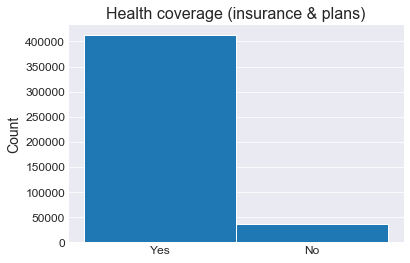

In [24]:
# Health coverage
health_coverage = df['HLTHPLN1'].copy().dropna(axis=0)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(health_coverage, bins=np.linspace(0.5, 2.5, 3), edgecolor='w')
ax.grid(axis='x')
ax.set_title('Health coverage (insurance & plans)', fontsize=16)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticks([1,2])
ax.set_xticklabels(['Yes','No'])
ax.tick_params(axis='both', which='major', labelsize=12)

#### [to overview](#general)
## <p id='sec4'>Section 4: Blood pressure</p>

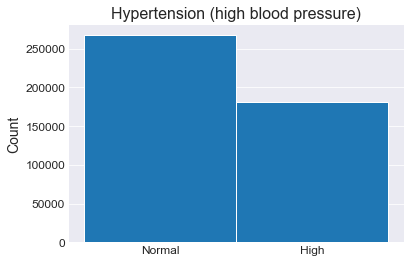

In [23]:
# Hypertension
hypertension = df['_RFHYPE5'].copy().dropna(axis=0).drop(df[df['_RFHYPE5']>2].index)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(hypertension, bins=np.linspace(0.5, 2.5, 3), edgecolor='w')
ax.grid(axis='x')
ax.set_title('Hypertension (high blood pressure)', fontsize=16)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticks([1,2])
ax.set_xticklabels(['Normal','High'])
ax.tick_params(axis='both', which='major', labelsize=12)

#### [to overview](#general)
## <p id='sec5'>Section 5: Cholesterol</p>

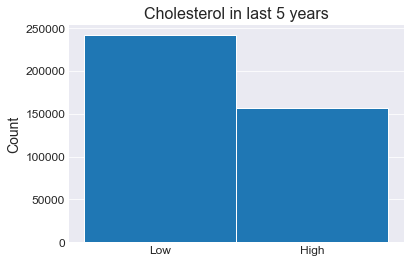

In [27]:
# Cholesterol
cholesterol = df['_RFCHOL1'].copy().dropna(axis=0).drop(df[df['_RFCHOL1']>2].index)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(cholesterol, bins=np.linspace(0.5,2.5,3), edgecolor='w')
ax.grid(axis='x')
ax.set_title('Cholesterol in last 5 years', fontsize=16)
ax.set_ylabel('Count',fontsize=14)
ax.set_xticks([1,2])
ax.set_xticklabels(['Low','High'])
ax.tick_params(axis='both', which='major', labelsize=12)

#### [to overview](#general)
## <p id='sec6'>Section 6: Chronic conditions</p>

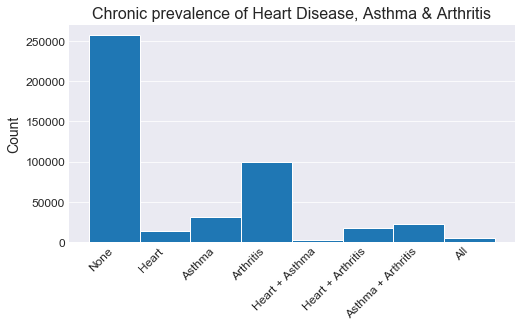

In [296]:
## Chronic heart, lung and bone problems
heart = df['_MICHD'].copy().values
heart[heart==2]=0
asthma = df['_LTASTH1'].copy().values
asthma[asthma==1]=0
asthma[asthma==2]=1
arthritis = df['_DRDXAR1'].copy().values
arthritis[arthritis==2]=0

cd=np.zeros(len(heart))
cd[np.where((heart==0)&(asthma==0)&(arthritis==0))[0]] = 0 # None
cd[np.where((heart==1)&(asthma==0)&(arthritis==0))[0]] = 1 # HE
cd[np.where((heart==0)&(asthma==1)&(arthritis==0))[0]] = 2 # AS
cd[np.where((heart==0)&(asthma==0)&(arthritis==1))[0]] = 3 # AR
cd[np.where((heart==1)&(asthma==1)&(arthritis==0))[0]] = 4 # HE / AS
cd[np.where((heart==1)&(asthma==0)&(arthritis==1))[0]] = 5 # HE / AR
cd[np.where((heart==0)&(asthma==1)&(arthritis==1))[0]] = 6 # AS / AR
cd[np.where((heart==1)&(asthma==1)&(arthritis==1))[0]] = 7 # HE / AS / AR

# Plot
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(cd, bins=np.linspace(0, 8, 9), edgecolor='w')
ax.grid(axis='x')
ax.set_title('Chronic prevalence of Heart Disease, Asthma & Arthritis', fontsize=16)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticks(np.linspace(0.5, 7.5, 8))
ax.set_xticklabels(['None','Heart','Asthma','Arthritis','Heart + Asthma','Heart + Arthritis',\
                    'Asthma + Arthritis','All'], rotation=45, ha='right')
ax.tick_params(axis='both', which='major', labelsize=12)
plt.show()

#### [to overview](#general)
## <p id='sec9'>Section 9: Smoking</p>

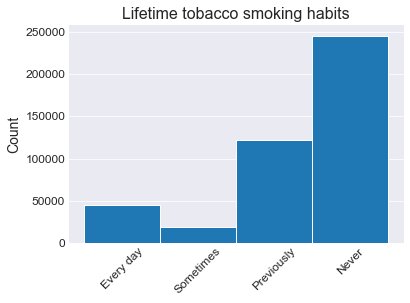

In [30]:
# Smoking tobacco
smoking = df['_SMOKER3'].copy().dropna(axis=0).drop(df[df['_RFCHOL1']>4].index)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(smoking, bins=np.linspace(0.5, 4.5, 5), edgecolor='w')
ax.grid(axis='x')
ax.set_title('Lifetime tobacco smoking habits', fontsize=16)
ax.set_ylabel('Count',fontsize=14)
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['Every day','Sometimes','Previously','Never'], rotation=45, ha='center')
ax.tick_params(axis='both', which='major', labelsize=12)

#### [to overview](#general)
## <p id='sec11'>Section 11: Drinking</p>

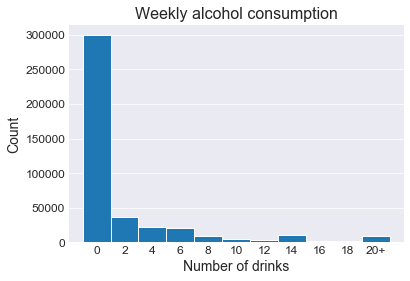

In [283]:
# Drinking alcohol
drinking = (df['_DRNKWEK'].copy().dropna(axis=0).drop(df[df['_DRNKWEK']>5000].index)/100).astype(int)
drinking[drinking>20] = 20

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(drinking, bins=np.linspace(-2, 22, 13), edgecolor='w')
ax.grid(axis='x')
ax.set_title('Weekly alcohol consumption', fontsize=16)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('Number of drinks', fontsize=14)
ax.set_xlim([-1,23])
ax.set_xticks(np.linspace(1, 21, 11))
ax.set_xticklabels(np.append(np.linspace(0, 18, 10, dtype=int), '20+'))
ax.tick_params(axis='both', which='major', labelsize=12)

#### [to overview](#general)
## <p id='sec12'>Section 12: Diet</p>

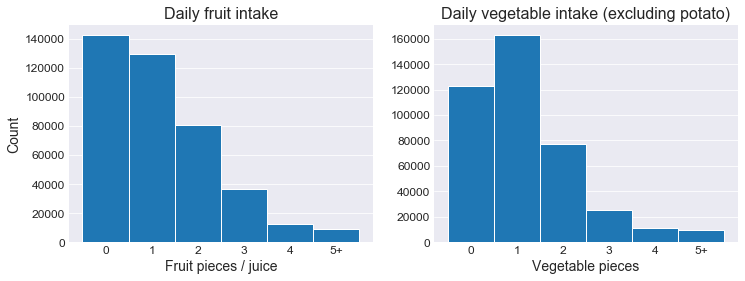

In [34]:
# Daily fruit juice
daily_fruit = (df['_FRUTSU1'].copy().dropna(axis=0).drop(df[df['FTJUDA2_']>9000].index)/100).astype(int)
veggies = df['GRENDA1_'] + df['VEGEDA2_']
daily_veggies = (veggies.dropna(axis=0).drop(veggies[veggies>9000].index)/100).astype(int)
daily_fruit[daily_fruit>5] = 5
daily_veggies[daily_veggies>5] = 5

# Plot
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

for i, ax in enumerate(axs):
    ax.grid(axis='x')
    if i==0:
        ax.hist(daily_fruit, bins=np.linspace(0,6,7), edgecolor='w')
        ax.set_title('Daily fruit intake', fontsize=16)
        ax.set_xlabel('Fruit pieces / juice', fontsize=14)
        ax.set_xticks(np.linspace(0.5, 5.5, 6))
        ax.set_xticklabels(np.append(np.linspace(0.5, 4.5, 5, dtype=int), '5+'))
        ax.set_ylabel('Count', fontsize=14)
    else:
        ax.hist(daily_veggies, bins=np.linspace(0, 6, 7), edgecolor='w')
        ax.set_title('Daily vegetable intake (excluding potato)', fontsize=16)
        ax.set_xlabel('Vegetable pieces', fontsize=14)
        ax.set_xticks(np.linspace(0.5, 5.5, 6))
        ax.set_xticklabels(np.append(np.linspace(0.5, 4.5, 5, dtype=int), '5+'))
    ax.tick_params(axis='both', which='major', labelsize=12)

#### [to overview](#general)
## <p id='sec13'>Section 13: Exercise</p>

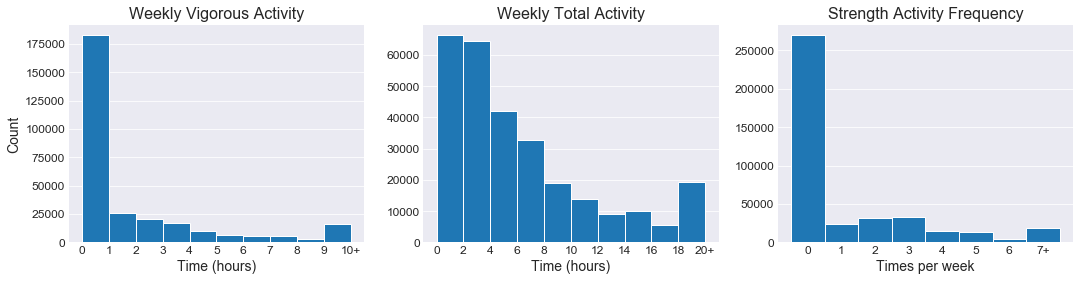

In [35]:
# Exercise numerical
activity_vigorous = df['PA1VIGM_'].copy().dropna(axis=0).drop(df[df['PA1VIGM_']>2000].index)
activity_total = df['PA1MIN_'].copy().dropna(axis=0).drop(df[df['PA1MIN_']>2000].index)
activity_strength = (df['STRFREQ_'].copy().dropna(axis=0).drop(df[df['STRFREQ_']>90000].index)/1000).astype(int)
activity_vigorous[activity_vigorous>600] = 600
activity_total[activity_total>1200] = 1200
activity_strength[activity_strength>7] = 7

# Plot
fig, axs = plt.subplots(ncols=3, figsize=(18, 4))

for i, ax in enumerate(axs):
    ax.grid(axis='x')
    if i==0:
        ax.hist(activity_vigorous, bins=np.linspace(0, 600, 11), edgecolor='w')
        ax.set_title('Weekly Vigorous Activity', fontsize=16)
        ax.set_xlabel('Time (hours)', fontsize=14)
        ax.set_xticks(np.linspace(0, 600, 11))
        ax.set_xticklabels(np.append(np.linspace(0, 9, 10, dtype=int), '10+'))
        ax.set_ylabel('Count', fontsize=14)
    elif i==1:
        ax.hist(activity_total, bins=np.linspace(0, 1200, 11), edgecolor='w')
        ax.set_title('Weekly Total Activity', fontsize=16)
        ax.set_xlabel('Time (hours)', fontsize=14)
        ax.set_xticks(np.linspace(0, 1200, 11))
        ax.set_xticklabels(np.append(np.linspace(0, 18, 10, dtype=int), '20+'))
    else:
        ax.hist(activity_strength, bins=np.linspace(-0.5, 7.5, 9), edgecolor='w')
        ax.set_title('Strength Activity Frequency', fontsize=16)
        ax.set_xticks(np.linspace(0, 7, 8))
        ax.set_xlabel('Times per week', fontsize=14)
        ax.set_xticklabels(np.append(np.linspace(0, 6, 7, dtype=int), '7+'))
    ax.tick_params(axis='both', which='major', labelsize=12)

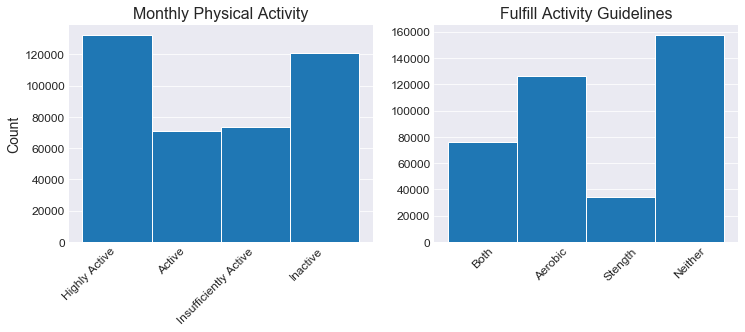

In [36]:
# Exercise categorical
activity_grp = df['_PACAT1'].copy().dropna(axis=0).drop(df[df['_PACAT1']>4].index)
activity_guide = df['_PAREC1'].copy().dropna(axis=0).drop(df[df['_PAREC1']>4].index)

# Plot
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

for i, ax in enumerate(axs):
    ax.grid(axis='x')
    if i==0:
        ax.hist(activity_grp, bins=np.linspace(0.5, 4.5, 5), edgecolor='w')
        ax.set_title('Monthly Physical Activity', fontsize=16)
        ax.set_xticks(np.linspace(1, 4, 4))
        ax.set_xticklabels(['Highly Active','Active','Insufficiently Active','Inactive'], rotation=45, ha='right')
        ax.set_ylabel('Count', fontsize=14)
    else:
        ax.hist(activity_guide, bins=np.linspace(0.5, 4.5, 5), edgecolor='w')
        ax.set_title('Fulfill Activity Guidelines', fontsize=16)
        ax.set_xticks(np.linspace(1, 4, 4))
        ax.set_xticklabels(['Both','Aerobic','Stength','Neither'], rotation=45, ha='center')
    ax.tick_params(axis='both', which='major', labelsize=12)

#### [to overview](#general)
## <p id='sec14'>Section 14: Seatbelts</p>

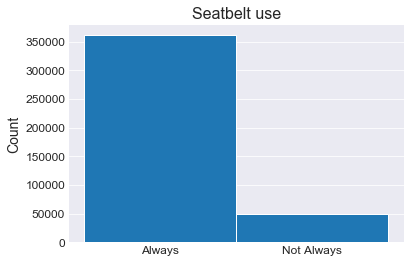

In [37]:
# Seatbelts
seatbelts = df['_RFSEAT3'].copy().dropna(axis=0).drop(df[df['_RFCHOL1']>2].index)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(seatbelts, bins=np.linspace(0.5, 2.5, 3), edgecolor='w')
ax.grid(axis='x')
ax.set_title('Seatbelt use', fontsize=16)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticks([1,2])
ax.set_xticklabels(['Always','Not Always'])
ax.tick_params(axis='both', which='major', labelsize=12)

#### [to overview](#general)
## <p id='sec15'>Section 15: Immunization</p>

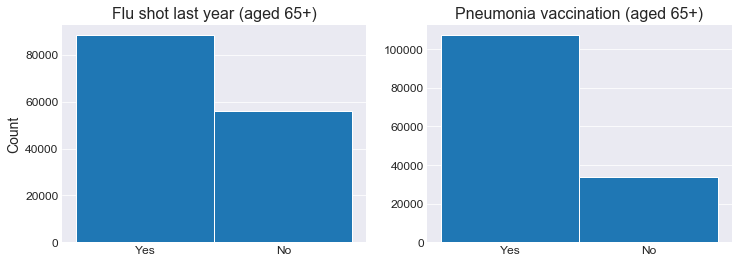

In [38]:
# Vaccinations
immune_flu = df['_FLSHOT6'].copy().dropna(axis=0).drop(df[df['_FLSHOT6']>2].index)
immune_pneumonia = df['_PNEUMO2'].copy().dropna(axis=0).drop(df[df['_PNEUMO2']>2].index)

# Plot
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

for i, ax in enumerate(axs):
    ax.grid(axis='x')
    if i==0:
        ax.hist(immune_flu, bins=np.linspace(0.5, 2.5, 3), edgecolor='w')
        ax.set_title('Flu shot last year (aged 65+)', fontsize=16)
        ax.set_ylabel('Count', fontsize=14)
    else:
        ax.hist(immune_pneumonia, bins=np.linspace(0.5, 2.5, 3), edgecolor='w')
        ax.set_title('Pneumonia vaccination (aged 65+)', fontsize=16)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['Yes','No'])
    ax.tick_params(axis='both', which='major', labelsize=12)

#### [to overview](#general)
## <p id='sec16'>Section 16: HIV/AIDS</p>

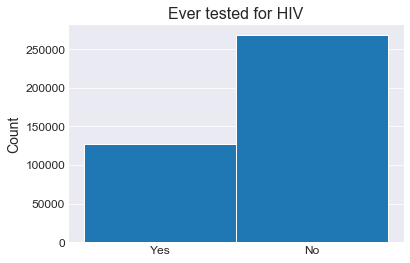

In [39]:
# Seatbelts
hiv = df['_AIDTST3'].copy().dropna(axis=0).drop(df[df['_AIDTST3']>2].index)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(hiv, bins=np.linspace(0.5, 2.5, 3), edgecolor='w')
ax.grid(axis='x')
ax.set_title('Ever tested for HIV', fontsize=16)
ax.set_ylabel('Count', fontsize=14)
ax.set_xticks([1,2])
ax.set_xticklabels(['Yes','No'])
ax.tick_params(axis='both', which='major', labelsize=12)

#### [to overview](#general)
## <p id='dataprep'>Data preparation</p>
<p>see: https://stats.stackexchange.com/questions/82923/mixing-continuous-and-binary-data-with-linear-svm<p>
<p>The original data has 359 columns, some of which are irrelevant and others are agregated to calculate total scores. We need to select only the relevant variables for analysis. The creators further used different coding schemes for scores and missing values. Hence we recode and scale everything consistently, and replace missing values, so we can feed it into our classifiers:</p>
<ul>
    <li><strong>Binary | </strong>+1 = yes, -1 = no</li>
    <li><strong>Ordinal | </strong>range from 1 (lowest) to # of categories (highest)</li>
    <li><strong>Continuous | </strong>range from -1 to +1, after capping at a reasonable value</li>
</ul>

In [3]:
print(columns)

['NUMADULT', '_CHLDCNT']


In [2]:
# Data to include
columns = ['NUMADULT','_CHLDCNT'] # General information
columns = np.append(columns, ['_AGE_G','HTM4','WTKG3','_BMI5','_BMI5CAT','_MRACE1','_EDUCAG','_INCOMG']) # Demographics
columns = np.append(columns, ['GENHLTH','_RFHLTH','PHYSHLTH','MENTHLTH','_PHYS14D','_MENT14D','HLTHPLN1']) # General health
columns = np.append(columns, ['_RFHYPE5','_RFCHOL1','_MICHD','_LTASTH1','_DRDXAR1']) # Conditions
columns = np.append(columns, ['_SMOKER3','_DRNKWEK','_FRUTSU1','GRENDA1_','VEGEDA2_']) # Diet
columns = np.append(columns, ['PA1VIGM_','PA1MIN_','STRFREQ_','_PACAT1','_PAREC1']) # Exercise
columns = np.append(columns, ['_RFSEAT3','_FLSHOT6','_PNEUMO2','_AIDTST3']) # Immunization

# Initialize
data = df[columns].copy()
data.head(5)

NameError: name 'np' is not defined

In [70]:
# Recoding all binary variables
col_binary = ['_RFHLTH','HLTHPLN1','_RFHYPE5','_RFCHOL1','_MICHD','_LTASTH1',\
              '_DRDXAR1','_RFSEAT3','_FLSHOT6','_PNEUMO2','_AIDTST3']

for i, col in enumerate(col_binary):
    
    # Set all values outside of 1/2 to nan
    uniq = data[col].unique()
    uniq = uniq[((uniq!=1.)&(uniq!=2.))]
    if uniq.any():
        data[col].replace(uniq, np.nan, inplace=True)
    
    # Set NA values to lowest value (in order to not bias to high-risk values)
    data[col] = data[col].fillna(data[col].min())
    
    # Recode into -1/+1
    data[col].replace(2, -1, inplace=True)
    
    # Invert order (-1 is now absence, +1 is presence of disease/risk factor)
    if (col=='_LTASTH1') | (col=='_RFCHOL1') | (col=='_RFHYPE5'):
        data[col] = data[col]*-1
        
    # Invert order (-1 is now absence, +1 is presence of preventive factor)
    if col=='_RFSEAT3':
        data[col] = data[col]*-1
    
    print(col, data[col].min(), data[col].max())

_RFHLTH -1.0 1.0
HLTHPLN1 -1.0 1.0
_RFHYPE5 -1.0 1.0
_RFCHOL1 -1.0 1.0
_MICHD -1.0 1.0
_LTASTH1 -1.0 1.0
_DRDXAR1 -1.0 1.0
_RFSEAT3 -1.0 1.0
_FLSHOT6 -1.0 1.0
_PNEUMO2 -1.0 1.0
_AIDTST3 -1.0 1.0


In [71]:
# Recoding all categorical variables
col_cat = ['_AGE_G','_BMI5CAT','_MRACE1','_EDUCAG','_INCOMG','GENHLTH',\
            '_PHYS14D','_MENT14D','_SMOKER3','_PACAT1','_PAREC1']
col_max = [6, 4, 7, 4, 5, 5, 3, 3, 4, 4, 4]

for i, col in enumerate(col_cat):
    
    # Set all values above max to nan
    uniq = data[col].unique()
    uniq = uniq[~np.isnan(uniq)]
    uniq_replace = uniq[uniq > col_max[i]]
    if uniq_replace.any():
        data[col].replace(uniq_replace, np.nan, inplace=True)
    
    # Replace na with mode
    data[col] = data[col].fillna(data[col].value_counts().index[0])
    
    # Invert order
    if col=='GENHLTH':
        data[col] = (data[col] - (data[col].max()+1)) * -1
    
    print(col, np.sort(data[col].unique()))

_AGE_G [1. 2. 3. 4. 5. 6.]
_BMI5CAT [1. 2. 3. 4.]
_MRACE1 [1. 2. 3. 4. 5. 6. 7.]
_EDUCAG [1. 2. 3. 4.]
_INCOMG [1. 2. 3. 4. 5.]
GENHLTH [1. 2. 3. 4. 5.]
_PHYS14D [1. 2. 3.]
_MENT14D [1. 2. 3.]
_SMOKER3 [1. 2. 3. 4.]
_PACAT1 [1. 2. 3. 4.]
_PAREC1 [1. 2. 3. 4.]


In [72]:
# Recoding all scale variables
col_scale = ['NUMADULT','_CHLDCNT','HTM4','WTKG3','_BMI5','PHYSHLTH','MENTHLTH','_DRNKWEK',\
            '_FRUTSU1','PA1VIGM_','PA1MIN_','STRFREQ_']

# Combine vegetable variables
if 'GRENDA1_' in data.columns:
    data['VEGGIES'] = data[['GRENDA1_','VEGEDA2_']].sum(axis=1)
    data.drop(columns=['GRENDA1_','VEGEDA2_'], inplace=True)
    col_scale.append('VEGGIES')

# Convert to correct units
data.loc[~data['WTKG3'].isna(), 'WTKG3'] = (data.loc[~data['WTKG3'].isna(), 'WTKG3']/100).astype(int)
data.loc[~data['_BMI5'].isna(), '_BMI5'] = (data.loc[~data['_BMI5'].isna(), '_BMI5']/100).astype(int)
data.loc[~data['_DRNKWEK'].isna(), '_DRNKWEK'] = (data.loc[~data['_DRNKWEK'].isna(), '_DRNKWEK']/100).astype(int)
data.loc[~data['_FRUTSU1'].isna(), '_FRUTSU1'] = (data.loc[~data['_FRUTSU1'].isna(), '_FRUTSU1']/100).astype(int)
data.loc[~data['VEGGIES'].isna(), 'VEGGIES'] = (data.loc[~data['VEGGIES'].isna(), 'VEGGIES']/100).astype(int)
data.loc[~data['STRFREQ_'].isna(), 'STRFREQ_'] = (data.loc[~data['STRFREQ_'].isna(), 'STRFREQ_']/1000).astype(int)
data.loc[~data['_CHLDCNT'].isna(), '_CHLDCNT'] = data.loc[~data['_CHLDCNT'].isna(), '_CHLDCNT']-1

# Remove extreme outliers
data.loc[data['PA1VIGM_']>2000, 'PA1VIGM_'] = np.nan
data.loc[data['PA1MIN_']>2000, 'PA1MIN_'] = np.nan
data.loc[data['STRFREQ_']>14, 'STRFREQ_'] = np.nan
data.loc[data['PHYSHLTH']>30, 'PHYSHLTH'] = np.nan
data.loc[data['_DRNKWEK']>100, '_DRNKWEK'] = np.nan
data.loc[data['_FRUTSU1']>10, '_FRUTSU1'] = np.nan
data.loc[data['VEGGIES']>10, 'VEGGIES'] = np.nan
data.loc[data['_BMI5']>50, '_BMI5'] = np.nan

# Cap at min/max of reasonable range
data.loc[((~data['WTKG3'].isna())&(data['WTKG3']>150)), 'WTKG3'] = 150
data.loc[((~data['WTKG3'].isna())&(data['WTKG3']<50)), 'WTKG3'] = 50
data.loc[((~data['HTM4'].isna())&(data['HTM4']>200)), 'HTM4'] = 200
data.loc[((~data['HTM4'].isna())&(data['HTM4']<140)), 'HTM4'] = 140
data.loc[((~data['PA1VIGM_'].isna())&(data['PA1VIGM_']>600)), 'PA1VIGM_'] = 600
data.loc[((~data['PA1MIN_'].isna())&(data['PA1MIN_']>1200)), 'PA1MIN_'] = 1200
data.loc[((~data['STRFREQ_'].isna())&(data['STRFREQ_']>7)), 'STRFREQ_'] = 7
data.loc[((~data['NUMADULT'].isna())&(data['NUMADULT']>5)), 'NUMADULT'] = 5
data.loc[((~data['_CHLDCNT'].isna())&(data['_CHLDCNT']>6)), '_CHLDCNT'] = 6
data.loc[((~data['_DRNKWEK'].isna())&(data['_DRNKWEK']>21)), '_DRNKWEK'] = 21
data.loc[((~data['_FRUTSU1'].isna())&(data['_FRUTSU1']>10)), '_FRUTSU1'] = 10
data.loc[((~data['VEGGIES'].isna())&(data['VEGGIES']>10)), 'VEGGIES'] = 10

# Standardize
for i, col in enumerate(col_scale):
    
    # Replace na with median
    data[col] = data[col].fillna(data[col].median())
    
    # Rescale into -1 to +1
    x = data[col]
    xr = (2*x - x.max() - x.min()) / (x.max() - x.min())
    data[col] = np.around(xr,2)
    
    # Standardize
#     xs = (x - np.mean(x)) / np.std(x)

In [73]:
data[col_scale].describe()

,NUMADULT,_CHLDCNT,HTM4,WTKG3,_BMI5,PHYSHLTH,MENTHLTH,_DRNKWEK,_FRUTSU1,PA1VIGM_,PA1MIN_,STRFREQ_,VEGGIES
count,449984.000000,449984.000000,449984.000000,449984.000000,449984.000000,449984.000000,449984.000000,449984.000000,449984.000000,449984.000000,449984.000000,449984.000000,449984.000000
mean,-0.552402,-0.816685,-0.005220,-0.381284,-0.187215,-0.466826,0.279690,-0.802772,-0.759861,-0.784646,-0.462703,-0.709013,-0.780166
std,0.262003,0.370424,0.344276,0.386214,0.293963,0.492443,0.741493,0.423407,0.245846,0.468789,0.441898,0.530742,0.242037
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.500000,-1.000000,-0.230000,-0.640000,-0.370000,-0.590000,-0.610000,-1.000000,-1.000000,-1.000000,-0.670000,-1.000000,-1.000000
50%,-0.500000,-1.000000,0.000000,-0.420000,-0.210000,-0.590000,0.780000,-1.000000,-0.800000,-1.000000,-0.580000,-1.000000,-0.800000
75%,-0.500000,-0.670000,0.270000,-0.200000,-0.050000,-0.590000,0.780000,-0.810000,-0.600000,-0.810000,-0.420000,-0.430000,-0.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### [to overview](#general)
## <p id='analysis'>Data analysis - Statistical models</p>
<p>Given the data, there is one major outcome variable we can work with: <i><strong>general health assessment</strong></i>. This is a self-reported value on an ordinal scale: <i>poor (1) / fair (2) / good (3) / very good (4) / excellent (5)</i>, although there is also a categorical version with <i>bad (1)</i> or <i>good (2)</i>. The first goal is to apply a set of statistical models to assess which recorded variables are associated with or predictive of health.</p>
<p>Below we apply the following classifiers to the data:</p>
<ol>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">Logistic Regression</a></li>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">Linear Regression</a></li>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html">Linear</a> and <a href="https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html">Quadratic</a> Discriminant Analysis (LDA/QDA)</li>
    <li><a href="https://scikit-learn.org/stable/modules/sgd.html">Linear SVM</a> using stochastic gradient descent (SGD)</li>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">Random Forest Classifier</a></li>
</ol>

In [74]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

In [75]:
# Variables for model
target_col = 'GENHLTH'
drop_col = [target_col,'_RFHLTH','_BMI5CAT','_PHYS14D','_MENT14D','_PACAT1','_PAREC1']
drop_col.append('PHYSHLTH') # removed for too much missing data - heavily biases results after filling na's
data_clf = data.copy()
data_clf.drop(columns=drop_col, inplace=True)
# feature_names = [x for x in data.columns.values if x not in drop_col]

# Split data into train and test sets
X = data_clf.values
y = data[target_col].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print('Features:', X_train.shape, X_test.shape)
print('Target:', y_train.shape, y_test.shape)

Features: (359987, 27) (89997, 27)
Target: (359987,) (89997,)


In [76]:
# Rename columns for interpretation
colname = {'NUMADULT':'n_adult', '_CHLDCNT':'n_children', '_AGE_G':'age', 'HTM4':'height',\
           'WTKG3':'weight', '_BMI5':'bmi', '_MRACE1':'race','_EDUCAG':'education', '_INCOMG':'income',\
           'MENTHLTH':'mental_health', 'HLTHPLN1':'health_cov', '_RFHYPE5':'blood_pressure',\
           '_RFCHOL1':'cholesterol', '_MICHD':'heart_disease', '_LTASTH1':'asthma', '_DRDXAR1':'arthritis', \
           '_SMOKER3':'smoking', '_DRNKWEK':'drinking', '_FRUTSU1':'fruits', 'PA1VIGM_':'excercise_vigorous', \
           'PA1MIN_':'physical_activity', 'STRFREQ_':'strength_activity', '_RFSEAT3':'seatbelt',\
           '_FLSHOT6':'flu_shot', '_PNEUMO2':'pneu_shot', '_AIDTST3':'aids_testing', 'VEGGIES':'veggies'}
data_clf.rename(columns=colname, inplace=True)
feature_names = data_clf.columns

In [77]:
# Baseline model of assigning the most frequent label to each instance
accuracies = dict()
accuracies['theory'] = 1 / len(data[target_col].unique())
baseline_prediction = np.full(y_test.shape, data[target_col].value_counts().index[0], dtype=int)
accuracies['baseline'] = accuracy_score(baseline_prediction, y_test)
print('Theoretical baseline accuracy:', accuracies['theory'])
print('Baseline model\'s accuracy:', accuracies['baseline'])

Theoretical baseline accuracy: 0.2
Baseline model's accuracy: 0.3258330833249997


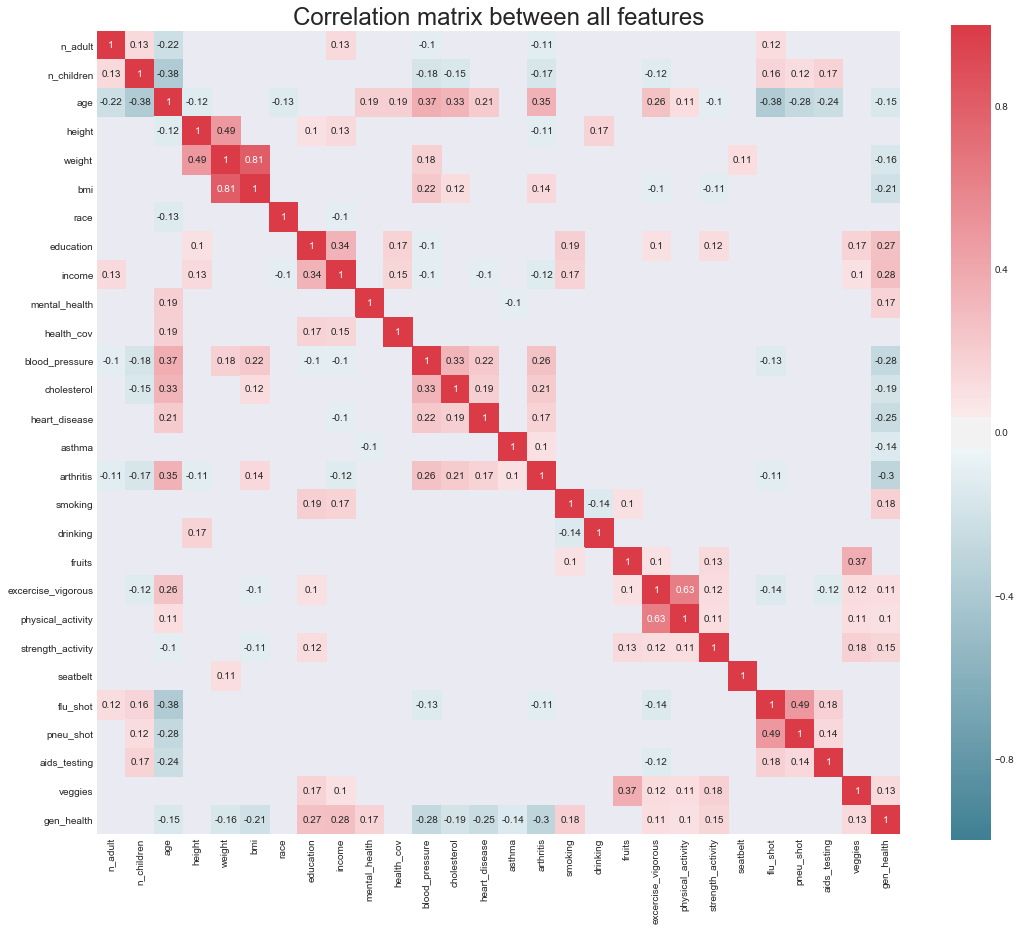

In [79]:
# Overall correlations between variables
tmp = data_clf.assign(gen_health=data[target_col]) 
corr = np.around(tmp.corr(),2)
corr[np.abs(corr)<.1] = np.nan
fig, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmin=-1, vmax=1, annot=True, square=True, ax=ax)
ax.set_title('Correlation matrix between all features', fontsize=24)
# plt.savefig('./images/img4.png',bbox_inches='tight')

## 1. Logistic Regression

In [80]:
from sklearn.linear_model import LogisticRegressionCV

In [81]:
# Logistic Regression (takes ~10 min)
logreg = LogisticRegressionCV(cv=5, solver='lbfgs', multi_class='multinomial', random_state=42)
logreg.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=42, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [82]:
# Performance
logreg_prediction = logreg.predict(X_test)
accuracies['logreg'] = accuracy_score(logreg_prediction, y_test)
print('R2:', logreg.score(X_test, y_test))
print('Logreg model\'s accuracy:', accuracies['logreg'])

R2: 0.42363634343367
Logreg model's accuracy: 0.42363634343367


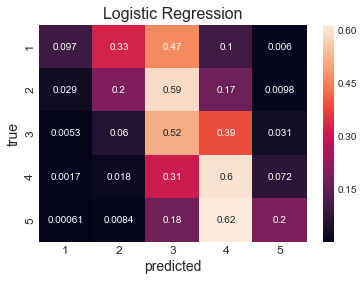

In [83]:
# Confusion Matrix
cm = confusion_matrix(y_test, logreg_prediction)
cm = cm.astype(float)/(cm.sum(axis=1)+.0000001)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(cm, annot=True, xticklabels=range(1,6), yticklabels=range(1,6))
plt.title('Logistic Regression', fontsize=16)
plt.xlabel('predicted', fontsize=14)
plt.ylabel('true', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

## 2. Linear Regression

In [84]:
from sklearn.linear_model import LinearRegression

In [85]:
# Linear Regression
linreg = LinearRegression()  
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [86]:
# Performance
linreg_prediction = np.around(linreg.predict(X_test))
accuracies['linreg'] = accuracy_score(linreg_prediction, y_test)
print('R2:', linreg.score(X_test, y_test))
print('Linreg model\'s accuracy:', accuracies['linreg'])

R2: 0.30325201973844973
Linreg model's accuracy: 0.41194706490216343


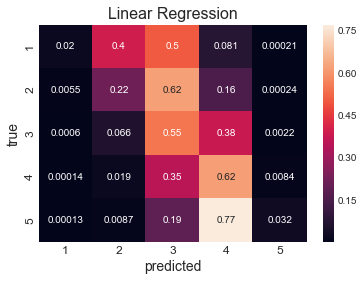

In [87]:
# Confusion Matrix
cm = confusion_matrix(y_test, linreg_prediction)
cm = cm.astype(float)/(cm.sum(axis=1)+.0000001)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(cm, annot=True, xticklabels=range(1,6), yticklabels=range(1,6))
ax.set_xlim([0,5])
ax.set_ylim([0,5])
ax.invert_yaxis()
plt.title('Linear Regression', fontsize=16)
plt.xlabel('predicted', fontsize=14)
plt.ylabel('true', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

## 3. Linear/Quadratic Discriminant Analysis (LDA/QDA)

In [88]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [89]:
# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

C:\Users\jvw\Anaconda2\envs\py36\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [90]:
# Performance
lda_prediction = lda.predict(X_test)
accuracies['lda'] = accuracy_score(lda_prediction, y_test)
print('LDA model\'s accuracy:', accuracies['lda'])

LDA model's accuracy: 0.4173472449081636


In [91]:
# QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [92]:
# Performance
qda_prediction = qda.predict(X_test)
accuracies['qda'] = accuracy_score(qda_prediction, y_test)
print('QDA model\'s accuracy:', accuracies['qda'])

QDA model's accuracy: 0.3727679811549274


## 4. Linear SVM using Stochastic Gradient Descent (SGD)

In [95]:
from sklearn.linear_model import SGDClassifier

In [97]:
# SGDC (takes few mins)
sgdc = SGDClassifier(max_iter=1000, random_state=42)
sgdc.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [98]:
# Performance
sgdc_prediction = np.around(sgdc.predict(X_test))
accuracies['sgdc'] = accuracy_score(sgdc_prediction, y_test)
print('SGDC model\'s accuracy:', accuracies['sgdc'])

SGDC model's accuracy: 0.3861239819105081


## 5. Random Forest Classifier
<ol>    
    <li><a>https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/</a></li>
    <li><a>https://towardsdatascience.com/random-forest-in-python-24d0893d51c0</a></li>
</ol>

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Hyperparameter tuning for Random Forest
# Note: This takes several hours!
param_grid = [
  {'max_depth': [2, 5, 10, 20, 30, 50]},
  {'n_estimators': [5, 10, 20, 50, 100, 200, 300]} ]
clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
clf.fit(X_train, y_train)

In [ ]:
# Store grid search results
cv_results = clf.cv_results_
sname = "C:/Users/jvw/Dropbox/programming/python/jvw-projects/project-4-health-risk-profiling/pickled/RFC_gridCV.p"
pickle.dump(cv_results, open(sname, "wb" ) )

In [101]:
# Load grid search results
lname = "C:/Users/jvw/Dropbox/programming/python/jvw-projects/project-4-health-risk-profiling/pickled/RFC_gridCV.p"
cv_results = pickle.load( open(lname, "rb" ) )

In [102]:
# Print best grid search results
means = cv_results['mean_test_score']
stds = cv_results['std_test_score']
for mean, std, params in zip(means, stds, cv_results['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.389 (+/-0.005) for {'max_depth': 2}
0.403 (+/-0.002) for {'max_depth': 5}
0.431 (+/-0.004) for {'max_depth': 10}
0.410 (+/-0.003) for {'max_depth': 20}
0.390 (+/-0.004) for {'max_depth': 30}
0.385 (+/-0.004) for {'max_depth': 50}
0.366 (+/-0.003) for {'n_estimators': 5}
0.386 (+/-0.003) for {'n_estimators': 10}
0.404 (+/-0.003) for {'n_estimators': 20}
0.420 (+/-0.003) for {'n_estimators': 50}
0.426 (+/-0.003) for {'n_estimators': 100}
0.430 (+/-0.002) for {'n_estimators': 200}
0.431 (+/-0.001) for {'n_estimators': 300}


In [103]:
# Run optimized Random Forest model (takes few mins)
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [104]:
# Most important features
feature_importance = pd.Series(rfc.feature_importances_, feature_names)
feature_importance.sort_values(ascending=False, inplace=True)
feature_importance[:10]

income               0.114325
blood_pressure       0.112664
arthritis            0.112478
mental_health        0.112454
education            0.097996
bmi                  0.082895
heart_disease        0.072995
strength_activity    0.044897
weight               0.037223
physical_activity    0.033345
dtype: float64

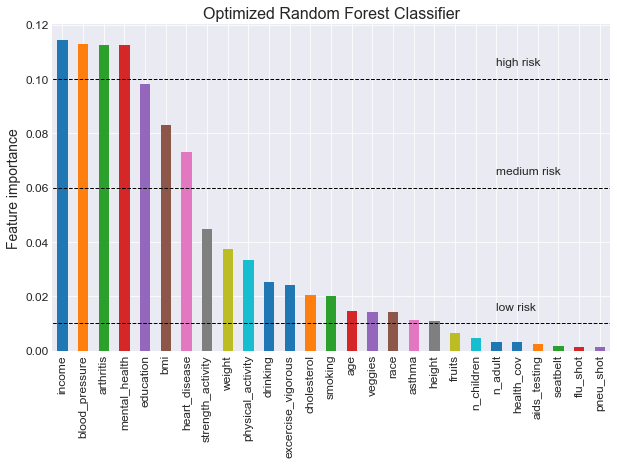

In [105]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Optimized Random Forest Classifier', fontsize=16)
plt.ylabel('Feature importance', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

cutoff = [0.10, 0.06, 0.01]
txt = ['high','medium','low']

for i,line in enumerate(cutoff):
    ax.plot([-1,len(feature_importance)], [line,line],'k--', linewidth=1)
    ax.text(len(feature_importance)-6, line+0.005, txt[i]+' risk', fontsize=12)

# plt.savefig('./images/img6.png',bbox_inches='tight')

In [106]:
# Performance
rfc_prediction = rfc.predict(X_test)
accuracies['rfc'] = accuracy_score(rfc_prediction, y_test)
print('Random Forest model\'s accuracy:', accuracies['rfc'])

Random Forest model's accuracy: 0.42768092269742325


## Comparing all model performances

In [109]:
# Store model performance
sname = "C:/Users/jvw/Dropbox/programming/python/jvw-projects/project-4-health-risk-profiling/pickled/Model_accuracies.p"
pickle.dump(accuracies, open(sname, "wb" ) )

In [110]:
# Load grid search results
lname = "C:/Users/jvw/Dropbox/programming/python/jvw-projects/project-4-health-risk-profiling/pickled/Model_accuracies.p"
accuracies = pickle.load( open(lname, "rb" ) )

Best model: rfc
Highest accuracy: 0.42768092269742325


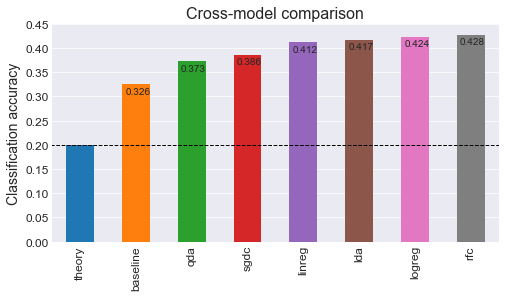

In [111]:
# Comparing all accuracies
acc = pd.Series(accuracies)
acc.sort_values(inplace=True)
print('Best model:', acc.idxmax())
print('Highest accuracy:', acc.max())

# Plot
col = plt.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(8, 4))
acc.plot(kind='bar', alpha=1, ax=ax)
ax.plot([-1,len(accuracies)], [accuracies['theory'],accuracies['theory']],'k--', linewidth=1)
plt.title('Cross-model comparison', fontsize=16)
plt.ylabel('Classification accuracy', fontsize=14)
ax.grid(axis='x')
ax.tick_params(axis='both', which='major', labelsize=12)

# Values
for i,m in enumerate(acc):
    if i>0:
        ax.text(i-0.19, m-0.02, np.round(m,3))
        
# plt.savefig('./images/img5.png',bbox_inches='tight')

## Building risk profiles on binary variables
<p>Thus far we've applied several statistical classifiers to identify features that are associated with self-reported health status. We will now focus on the low health status group, and isolate factors that are over-represented in this population. Only binary data is used, from which we can compute population risk factors.

In [39]:
# Variables for model
col_risk = ['_AGE_G','_BMI5CAT','_EDUCAG','_INCOMG','_RFHYPE5','_RFCHOL1',\
            '_MICHD','_LTASTH1','_DRDXAR1','_SMOKER3','_DRNKWEK','_FRUTSU1','VEGGIES',\
            '_PACAT1','_RFSEAT3','_FLSHOT6','_PNEUMO2','_AIDTST3']
data_risk = data[col_risk].copy()
data_target = data['_RFHLTH'].copy()

# Rename
colname = {'_AGE_G':'age', '_BMI5CAT':'bmi', '_EDUCAG':'education', '_INCOMG':'income','_RFHYPE5':'blood_pressure',\
           '_RFCHOL1':'cholesterol', '_MICHD':'heart_disease', '_LTASTH1':'asthma', '_DRDXAR1':'arthritis', \
           '_SMOKER3':'smoking', '_DRNKWEK':'drinking', '_FRUTSU1':'fruits', '_PACAT1':'excercise','_RFSEAT3':'seatbelt',\
           '_FLSHOT6':'flu_shot', '_PNEUMO2':'pneu_shot', '_AIDTST3':'aids_testing', 'VEGGIES':'veggies'}
data_risk.rename(columns=colname, inplace=True)

In [40]:
# Rescale ordinal variables to binary risk/preventive categories
data_risk.loc[data_risk['age']<5, 'age'] = -1
data_risk.loc[data_risk['age']>0, 'age'] = 1
data_risk.loc[data_risk['bmi']<3, 'bmi'] = -1
data_risk.loc[data_risk['bmi']>0, 'bmi'] = 1
data_risk.loc[data_risk['education']<3, 'education'] = -1
data_risk.loc[data_risk['education']>0, 'education'] = 1
data_risk.loc[data_risk['income']<4, 'income'] = -1
data_risk.loc[data_risk['income']>0, 'income'] = 1
data_risk.loc[data_risk['smoking']>2, 'smoking'] = -1
data_risk.loc[data_risk['smoking']>0, 'smoking'] = 1
data_risk.loc[data_risk['excercise']>2, 'excercise'] = -1
data_risk.loc[data_risk['excercise']>0, 'excercise'] = 1

In [41]:
# Rescale continuous variables to binary risk/preventive categories
data_risk.loc[data_risk['drinking']>-1, 'drinking'] = 1
data_risk.loc[data_risk['fruits']>-1, 'fruits'] = 1
data_risk.loc[data_risk['veggies']>-1, 'veggies'] = 1

In [43]:
# Calculate the odds ratio (OR) for each variable
odds = pd.Series(index=data_risk.columns)
for ind in odds.index:
    odds[ind] = get_odds_ratio(ind)

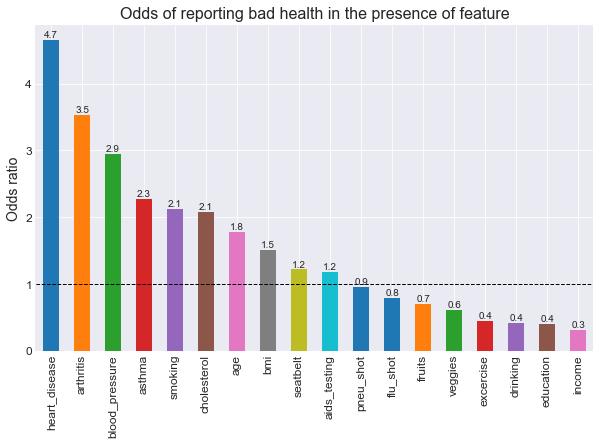

In [64]:
# Plot odds ratios
fig, ax = plt.subplots(figsize=(10, 6))
odds.plot(kind='bar')
ax.plot([-1,len(odds)], [1,1],'k--', linewidth=1)
plt.title('Odds of reporting bad health in the presence of feature', fontsize=16)
plt.ylabel('Odds ratio', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Values
for i,odd in enumerate(odds):
    ax.text(i-0.22, odd+0.04, np.round(odd,1))
    
# plt.savefig('./images/img7.png',bbox_inches='tight')